# Машинное обучение

# Семинар 2

В данном notebook'е мы изучим некоторые особенности поведения стохастического градиентного спуска, сравним его с (полным) градиентным спуском, покажем, насколько мощным инстументом для анализа данных может служить линейная регрессия, а также научимся запускать её в несколько строк кода.

## Градиентный спуск

Выпишем ещё раз явную формулу параметров линейной модели:

$$w = (X^TX)^{-1}X^Ty.$$

Здесь присутствует обращение матрицы $X^TX$ — очень трудоёмкая операция при большом количестве признаков. Нетрудно подсчитать, что сложность вычислений $O(d^3 + d^2l)$. При решении задач такая трудоёмкость часто оказывается непозволительной, поэтому параметры ищут итерационными методами, стоимость которых меньше. Один из них — градиентный спуск.

Напомним, что в градиентном спуске значения параметров на следующем шаге получаются из значений параметров на текущем шаге смещением в сторону антиградиента функционала: 

$$w^{(k+1)} = w^{(k)} - \eta_k \nabla Q(w^{(k)}),$$
где $\eta_k$ — шаг градиентного спуска.

Формула градиента функции ошибки выглядит следующим образом:

$$\nabla Q(w) = -2X^Ty + 2X^TXw = 2X^T(Xw - y).$$
 
Сложность вычислений в данном случае $O(dl)$. Стохастический градиентный спуск отличается от обычного заменой градиента на несмещённую оценку по одному или нескольким объектам. В этом случае сложность становится $O(kd)$, где $k$ — количество объектов, по которым оценивается градиент, $k << l$. Это отчасти объясняет популярность стохастических методов оптимизации.

### Визуализация траекторий GD и SGD
На простом примере разберём основные тонкости, связанные со стохастической оптимизацией.

In [1]:
%pylab inline
np.random.seed(16)

Populating the interactive namespace from numpy and matplotlib


Создадим данные для эксперимента следующим образом: сгенерируем вектор параметров $w_{true}$ и матрицу объекты признаки $X$. Вектор из целевых переменных $Y$ будет вычисляться как зашумлённая версия $Xw_{true}$:

In [2]:
n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]  # for different scales
Y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_0 = np.random.uniform(-2, 2, (n_features))

Обучим линейную регрессию (в случае среднеквадратичной ошибки) для этих данных при помощи GD — тем самым получим значения параметров.

In [3]:
w = w_0.copy()
w_list = [w.copy()]
step_size = 1e-2

for i in range(num_steps):
    w -= 2 * step_size * np.dot(X.T, np.dot(X, w) - Y) / Y.shape[0]
    w_list.append(w.copy())
w_list = np.array(w_list)

Покажем последовательность оценок параметров $w$, получаемых в ходе итераций. Красная точка — $w_{true}$.

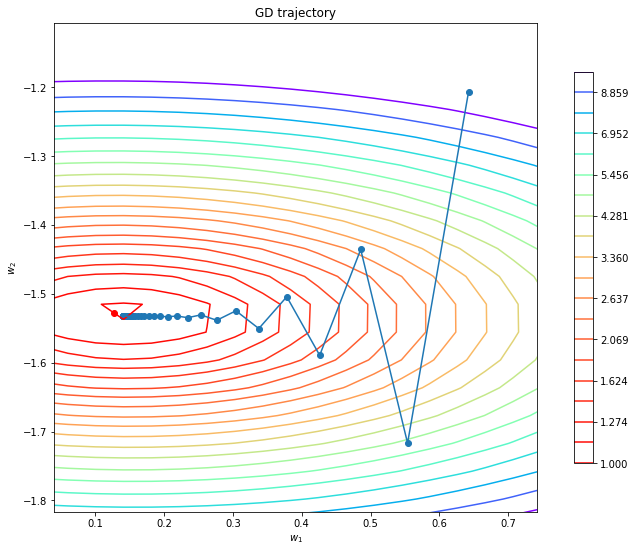

In [4]:
# compute level set
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))


plt.figure(figsize=(13, 9))
plt.title('GD trajectory')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1))
plt.ylim((w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1))
plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()

Чуть ранее мы доказали, что градиент перпендикулярен линиям уровня. Это объясняет такие зигзагообразные траектории градиентного спуска. Для большей наглядности в каждой точке пространства посчитаем градиент функционала и покажем его направление.

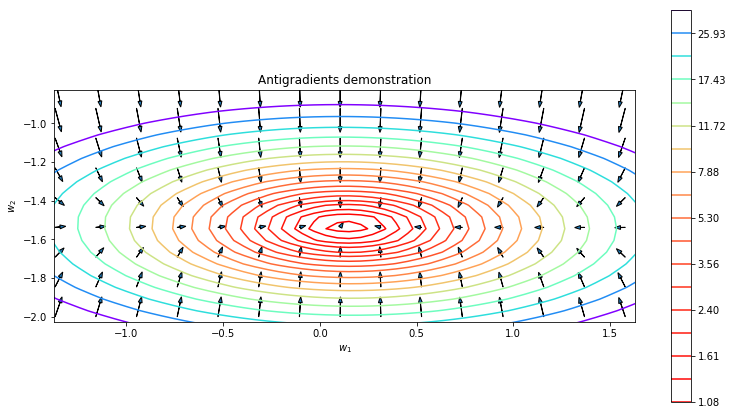

In [5]:
# compute level set
A, B = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
A_mini, B_mini = np.meshgrid(np.linspace(-2, 2, 20), np.linspace(-2, 2, 27))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))
        
# visualize the level set
plt.figure(figsize=(13, 9))
CS = plt.contour(A, B, levels, levels=np.logspace(-1, 1.5, num=30), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
        
# visualize the gradients
gradients = np.empty_like(A_mini)
for i in range(A_mini.shape[0]):
    for j in range(A_mini.shape[1]):
        w_tmp = np.array([A_mini[i, j], B_mini[i, j]])
        antigrad = - 2*1e-3 * np.dot(X.T, np.dot(X, w_tmp) - Y) / Y.shape[0]
        plt.arrow(A_mini[i, j], B_mini[i, j], antigrad[0], antigrad[1], head_width=0.02)

plt.title('Antigradients demonstration')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_true[0] - 1.5, w_true[0] + 1.5))
plt.ylim((w_true[1] - .5, w_true[1] + .7))
plt.gca().set_aspect('equal')
plt.show()

Визуализируем теперь траектории SGD, повторив те же самые действия за исключением того, что градиент будет оцениваться по подвыборке.

In [6]:
w = w_0.copy()
w_list = [w.copy()]
step_size = 0.2

for i in range(num_steps):
    sample = np.random.randint(n_objects, size=batch_size)
    w -= 2 * step_size * np.dot(X[sample].T, np.dot(X[sample], w) - Y[sample]) / Y.shape[0]
    w_list.append(w.copy())
w_list = np.array(w_list)

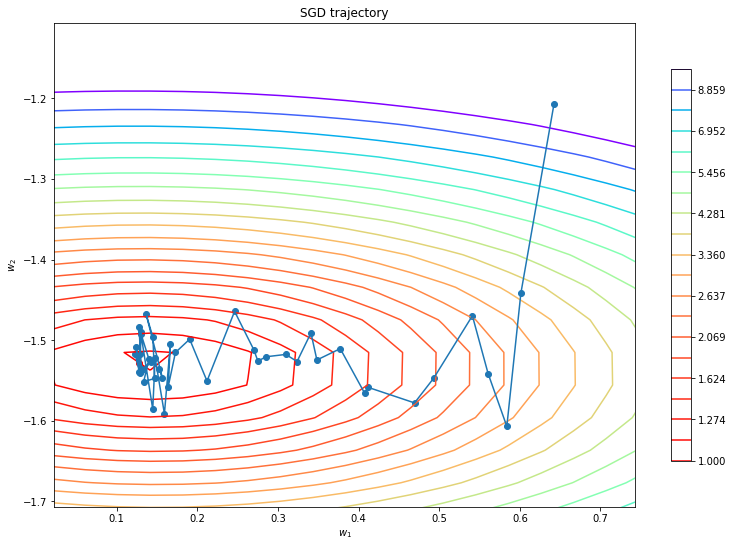

In [7]:
# compute level set
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))


plt.figure(figsize=(13, 9))
plt.title('SGD trajectory')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1))
plt.ylim((w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1))
plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()

Как видно, стохастический градиент «бродит» около оптимума. Это объясняется подбором шага градиентного спуска $\eta_k$. Дело в том, что для сходимости стохастического градиентного спуска для последовательности шагов $\eta_k$ должны выполняться [условия Роббинса-Монро](https://projecteuclid.org/download/pdf_1/euclid.aoms/1177729586):
$$
\sum_{k = 1}^\infty \eta_k = \infty, \qquad \sum_{k = 1}^\infty \eta_k^2 < \infty.
$$
Интуитивно это означает следующее: 
1. последовательность должна расходиться, чтобы метод оптимизации мог добраться до любой точки пространства, 
2. но расходиться не слишком быстро.

Попробуем посмотреть на траектории SGD, последовательность шагов которой удовлетворяет условиям Роббинса-Монро:

In [8]:
w = w_0.copy()
w_list = [w.copy()]
step_size_0 = 0.45

for i in range(num_steps):
    step_size = step_size_0 / ((i+1)**0.51)
    sample = np.random.randint(n_objects, size=batch_size)
    w -= 2 * step_size * np.dot(X[sample].T, np.dot(X[sample], w) - Y[sample]) / Y.shape[0]
    w_list.append(w.copy())
w_list = np.array(w_list)

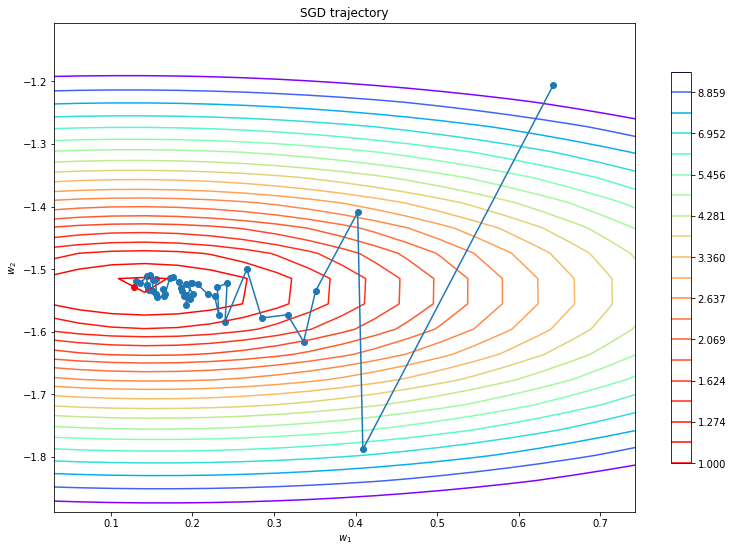

In [9]:
# compute level set
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))


plt.figure(figsize=(13, 9))
plt.title('SGD trajectory')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1))
plt.ylim((w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1))
#plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()

### Сравнение скоростей сходимости

Последнее, что хотелось бы продемонстрировать — сравнение, насколько быстро достигают оптимума метод полного и стохастического градиентного спуска. Сгенерируем выборку и построим график зависимости функционала от итерации.

In [10]:
# data generation
n_features = 50
n_objects = 1000
num_steps = 200
batch_size = 2

w_true = np.random.uniform(-2, 2, n_features)

X = np.random.uniform(-10, 10, (n_objects, n_features))
Y = X.dot(w_true) + np.random.normal(0, 5, n_objects)

In [11]:
step_size_sgd = 1
step_size_gd = 1e-2
w_sgd = np.random.uniform(-4, 4, n_features)
w_gd = w_sgd.copy()
residuals_sgd = [np.mean(np.power(np.dot(X, w_sgd) - Y, 2))]
residuals_gd = [np.mean(np.power(np.dot(X, w_gd) - Y, 2))]

for i in range(num_steps):
    step_size = step_size_sgd / ((i+1) ** 0.51)
    sample = np.random.randint(n_objects, size=batch_size)
    w_sgd -= 2 * step_size * np.dot(X[sample].T, np.dot(X[sample], w_sgd) - Y[sample]) / Y.shape[0]
    residuals_sgd.append(np.mean(np.power(np.dot(X, w_sgd) - Y, 2)))
    
    w_gd -= 2 * step_size_gd * np.dot(X.T, np.dot(X, w_gd) - Y) / Y.shape[0]
    residuals_gd.append(np.mean(np.power(np.dot(X, w_gd) - Y, 2)))

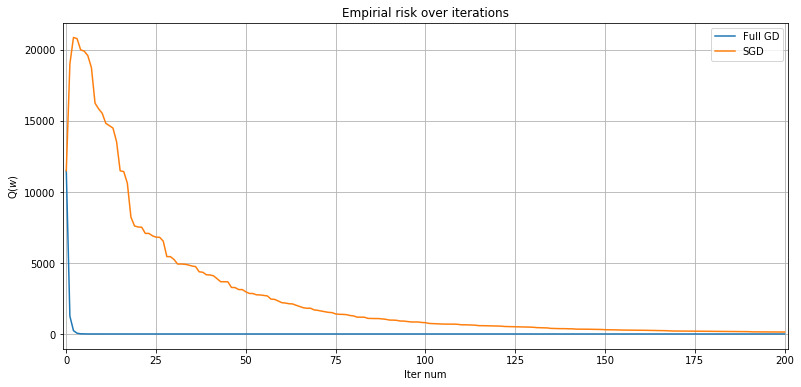

In [12]:
plt.figure(figsize=(13, 6))
plt.plot(range(num_steps+1), residuals_gd, label='Full GD')
plt.plot(range(num_steps+1), residuals_sgd, label='SGD')
plt.title('Empirial risk over iterations')
plt.xlim((-1, num_steps+1))
plt.legend()
plt.xlabel('Iter num')
plt.ylabel(r'Q($w$)')
plt.grid()
plt.show()

Как видно, GD буквально за несколько итераций оказывается вблизи оптимума, в то время как поведение SGD может быть весьма нестабильным. Как правило, для более сложных моделей наблюдаются ещё большие флуктуации в зависимости качества функционала от итерации при использовании стохастических градиентных методов. Путём подбора величины шага можно добиться лучшей скорости сходимости, и существуют методы, адаптивно подбирающие величину шага (AdaGrad, Adam, RMSProp).

## Линейная регрессия

Начнём с небольшой истории. В 16 веке [Галилео Галилей](https://ru.wikipedia.org/wiki/Галилей,_Галилео) изучал законы механики, и, в частности, законы падения тел. Он хотел установить зависимость между пройденным путём свободно падающего тела и временем его падения. Так как в то время не было достаточно точных инструментов для измерения времени падения тела, Галилей поставил другой эксперимент. А именно, он скатывал бронзовый шар с наклонной плоскости, замерял пройденный им путь и затраченное на это время (время Галилей измерял с помощью [водяных часов](https://ru.wikipedia.org/wiki/Водяные_часы)).

К сожалению, лабораторных таблиц Галилея у нас нет, но мы можем с лёгкостью смоделировать данный эксперимент.

In [13]:
n_exps = 100

g = 9.81
a = np.sin(np.pi / 6.0) * g
t = np.linspace(1, 5, n_exps)
x = a*t**2/2 + np.random.normal(0, 2,n_exps)

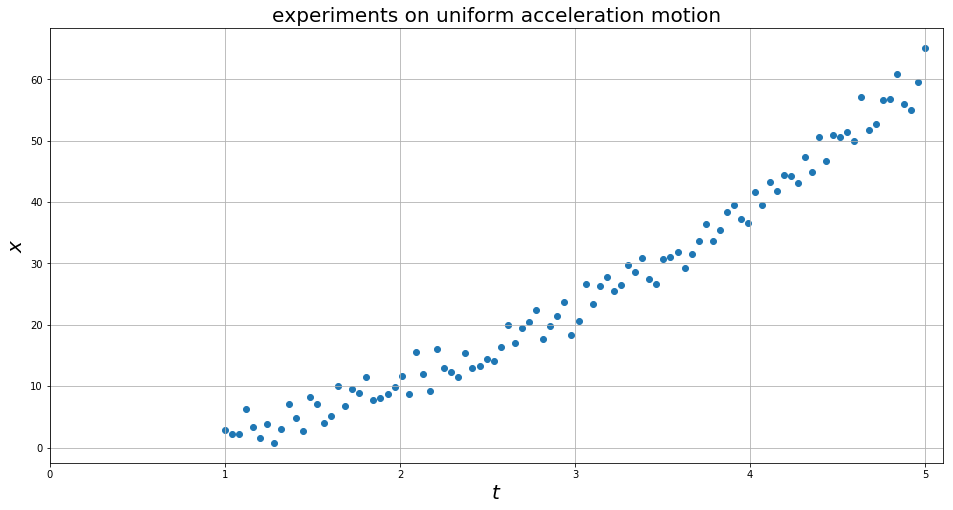

In [14]:
figsize(16,8)
plt.scatter(t,x)

plt.title('experiments on uniform acceleration motion', fontsize=20)
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$x$', fontsize=20)
plt.xlim(0.0, 5.1)
plt.grid()

Как и ожидалось, это парабола. Но Галилей не знал этого, а к тому же был культурным и образованым человеком, и ему необходимы были строгие доказательства.

[comment]: <> (<img src="http://picscomment.com/wp-content/themes/bunker/inc/download.php?file=35311433416143.jpg">)

Поэтому он построил следующий график:

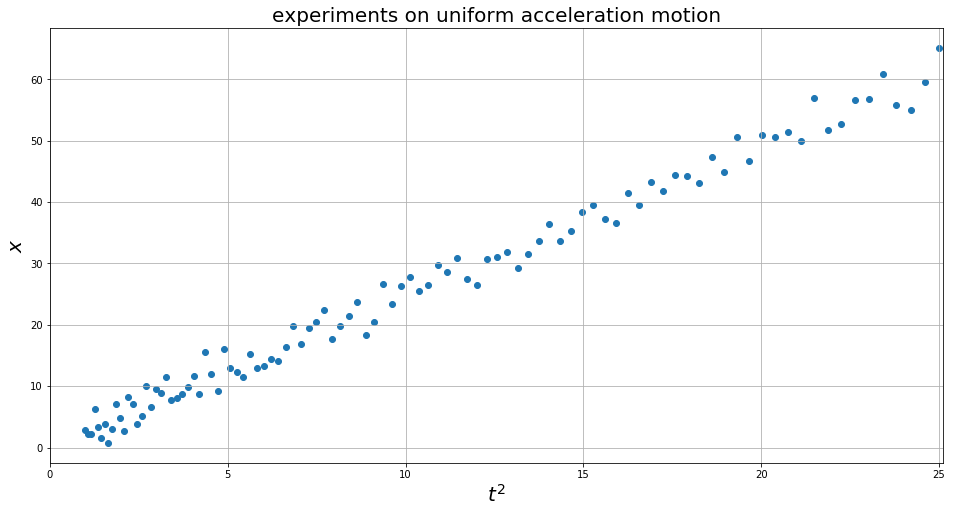

In [15]:
figsize(16, 8)
plt.scatter(t**2, x)

plt.title('experiments on uniform acceleration motion', fontsize=20)
plt.xlabel('$t^2$', fontsize=20)
plt.ylabel('$x$', fontsize=20)
plt.xlim(0.0, 25.1)
plt.grid()

Несмотря на свою простоту, этот приём не такой очевидный, каким может показаться на первый взгляд. И к тому же очень полезный!

Дело в том, что к такому графику вы можете приложить линейку и понять, что это прямая (во времена Галлилея). Также существуют стандартные статистические тесты для проверки такой гипотезы (в наше время). В случае с параболой всё усложняется, поэтому необходимо помнить про этот приём.

Оказывается, что линейная регрессия — это очень мощный инструмент, если мы можем подбирать коэффициенты степенного ряда. Таким образом мы можем приближать любую функцию, не зная её вид, а подбирая коэффициенты в ряде Тейлора.

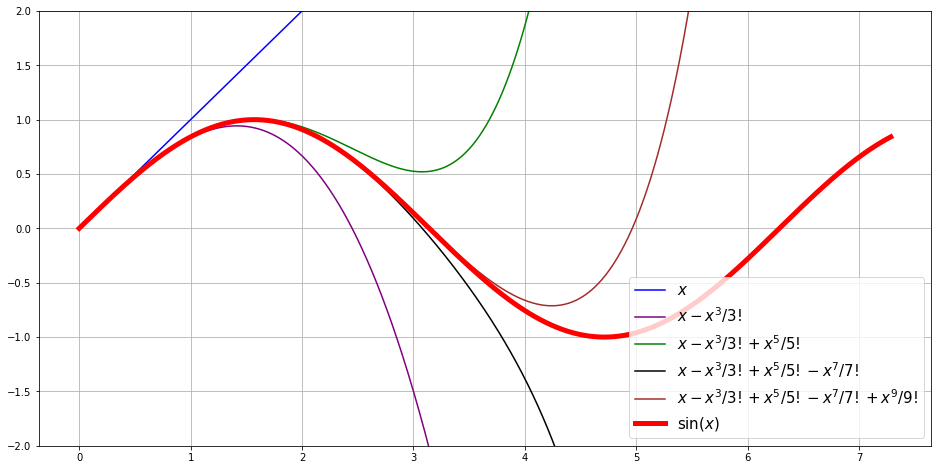

In [16]:
x = np.arange(0, 2*np.pi + 1, 0.001)
y_1 = x
y_2 = x - x**3 / np.math.factorial(3)
y_3 = x - x**3 / np.math.factorial(3) + x**5 / np.math.factorial(5)
y_4 = x - x**3 / np.math.factorial(3) + x**5 / np.math.factorial(5) - x**7 / np.math.factorial(7)
y_5 = x - x**3 / np.math.factorial(3) + x**5 / np.math.factorial(5) - x**7 / np.math.factorial(7) \
    + x**9 / np.math.factorial(9)

figsize(16, 8)
plt.ylim(-2., 2.)
plt.plot(x,y_1,color='blue',label='$x$')
plt.plot(x,y_2,'purple',label='$x - x^3/3!$')
plt.plot(x,y_3,'green',label='$x - x^3/3! + x^5/5!$')
plt.plot(x,y_4,'black',label='$x - x^3/3! + x^5/5! - x^7/7!$')
plt.plot(x,y_5,'brown',label='$x - x^3/3! + x^5/5! - x^7/7! + x^9/9!$')
plt.plot(x,np.sin(x),color='r',lw=5,label='$\sin(x)$')
plt.legend(fontsize=15, loc=4)
plt.grid()

## Линейная регрессия из коробки

Наконец, необходимо уметь запускать линейную регрессию из коробки (в нашем случае из scikit-learn). Но при запуске необходимо читать что внутри! В качестве примера сравним время настройки одной и той же модели, но двумя разными методами. Сравним объект LinearRegression, и объект Ridge. LinearRegression решает обычную задачу линейной регрессии, а объект Ridge добавляет $L_2$ регуляризацию весов.

Помимо времени работы сравним получаемые коэффициенты детерминации $R^2$.

$$R^2 = 1 - \frac{\sum_i (y_i - a(x_i))^2}{\sum_i (y_i - \overline{y}_i)^2}$$

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [18]:
n_features = 700
n_objects = 100000
num_steps = 150

w_true = np.random.uniform(-2, 2, (n_features, 1))

X = np.random.uniform(-100, 100, (n_objects, n_features))
Y = X.dot(w_true) + np.random.normal(0, 10, (n_objects, 1))

In [19]:
%%time

lr = LinearRegression()
lr.fit(X,Y)
print('R2: %f' % lr.score(X,Y))

R2: 0.999968
CPU times: user 16.5 s, sys: 1.2 s, total: 17.7 s
Wall time: 10.5 s


In [20]:
%%time

lr = Ridge(alpha=0.0, solver='sparse_cg')
lr.fit(X,Y)
print('R2: %f' % lr.score(X,Y))

R2: 0.999968
CPU times: user 1.43 s, sys: 493 ms, total: 1.92 s
Wall time: 1.43 s


На данном примере мы наблюдаем разницу во времени в несколько раз. Дело в том, что в первом классе (LinearRegression) задача решается явным образом — через обращение матрицы, а в классе Ridge мы выбрали градиентный метод решения (если быть точным — метод сопряжённого градиента).